In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 32.4 MB/s eta 0:00:00


# 1. Matrix Generator

In [ ]:

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
import numpy as np
import pandas as pd

"""
  Função que recebe como entrada um arquivo contendo moléculas no formato smiles
  e retorna um DataFrame contendo a matriz de fingerprints dos respectivos smiles
"""

def matrix_generator(smiles_file):
  with open(smiles_file) as in_file:

    lines = in_file.readlines()
    matrix = []
    names = []

    for line in lines:
      if '\t' in line:
        smiles = line.split('\t')[0].strip()
        name = line.split('\t')[1].strip()
      else:
        smiles = line.split(' ')[0].strip()
        name = line.split(' ')[1].strip()

      molecule = Chem.MolFromSmiles(smiles)

      if molecule is None:
        continue

      # Topological Fingerprints 2048 bits
      fp1 = Chem.RDKFingerprint(molecule)
      # MACCS Keys 167 bits
      fp2 = MACCSkeys.GenMACCSKeys(molecule)
      # Concatena fingerprints
      fp_final = list(fp1.ToBitString() + fp2.ToBitString())
      # tranforma em uma lista de inteiros
      matrix.append([int(x) for x in fp_final])
      names.append(name)

    df = pd.DataFrame(matrix, index=names)
    df.index.name = "name"
    return df

## 1.1 Executando o matrix_generator

In [ ]:
work_dir = "/content/drive/MyDrive/Toy_Example_COVID/"

# Definindo caminho dos arquivos
ligand_smiles = work_dir + "data/ligands.smiles"
decoy_smiles  = work_dir + "data/decoys.smiles"

# Gerando DatFrame para ligantes
ligands_df = matrix_generator(ligand_smiles)  # 74 ligantes
ligands_df['class'] = 1
ligands_df.to_csv(work_dir + 'data/ligands_matrix.csv')

# Gerando DatFrame para decoys
decoys_df = matrix_generator(decoy_smiles)  # 3850 decoys
decoys_df['class'] = 0
decoys_df.to_csv(work_dir + 'data/decoys_matrix.csv')

# Concatenando DataFrames
matrix = pd.concat([ligands_df, decoys_df])

# Salvando matriz no Drive
matrix.to_csv(work_dir + 'data/full_matrix.csv')

# 2. Pré-Processamento

In [ ]:
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
import random

# importa matrix de dados criada na etapa 1.1
train_set = pd.read_csv(work_dir + "data/full_matrix.csv", index_col='name')

#retira colunas iguais e colunas com todos valores iguais
#train_set.insert(0, "zeros", 0, allow_duplicates=False)
#train_set.insert(1, "uns", 1, allow_duplicates=False)
#train_set = train_set.T.drop_duplicates().T
#train_set = train_set.drop_duplicates()
#train_set = train_set.drop(['uns','zeros'], axis=1)

# Balanceamento dos dados
decoys = train_set[train_set['class'] == 0]
ligands = train_set[train_set['class'] == 1]
# Subamostrando exemplos da classe majoritária (decoys)
decoys_resampled = resample(decoys, n_samples=len(ligands))
# Concatenando os exemplos subamostrados com os exemplos da classe minoritária (decoys)
train_set = pd.concat([decoys_resampled, ligands])

# Embaralhando os dados
n_rows = len(train_set)
# Cria uma lista com o índice de todas as linhas
idx_list = list(range(n_rows))
# Embaralha a lista de índices
random.shuffle(idx_list)
# Usa a lista de índices embaralhada para reordenar as linhas do conjunto de dados
train_set = train_set.iloc[idx_list,:]

# separqando os dados em features e targets
X = train_set.iloc[:,:-1]
y = train_set.iloc[:,-1]

# escalonando os dados de treinamento usando StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 4. Cross Validation
* Avaliando o modelo de Regressão Logística

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

# criando o modelo base
clf = LogisticRegressionCV(max_iter=1000, random_state=42)

# definindo os valores para os hiperparâmetros que queremos testar
param_grid = {
    'Cs': [0.01, 0.1, 1, 10],
    'cv': [3, 5, 10, 20],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, "balanced"],
    'solver': ["lbfgs", "liblinear", "saga", "newton-cg"]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X, y)

# Ver os melhores hiperparâmetros encontrados
print(grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
800 fits failed out of a total of 1280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1760, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sk

{'Cs': 10, 'class_weight': 'balanced', 'cv': 3, 'penalty': 'l2', 'solver': 'lbfgs'}


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(max_iter=1000, random_state=42, Cs=10, class_weight='balanced', cv=3, penalty='l2', solver='lbfgs')

recall = cross_val_score(clf, X, y, cv=5, scoring='recall')
precision = cross_val_score(clf, X, y, cv=5, scoring='precision')
auc = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')

print("AUC: ", round(auc.mean(), 2), " +/-", round(auc.std(), 2))
print("precision: ", round(precision.mean(), 2), " +/-", round(precision.std(), 2))
print("recall: ", round(recall.mean(), 2), " +/-", round(recall.std(), 2))

AUC:  0.97  +/- 0.03
precision:  0.95  +/- 0.05
recall:  0.92  +/- 0.08


# 5. Screening
* Usando o modelo de Regressão Logística para classificar compostos no drugbank

In [ ]:
drugbank_dataset = pd.read_csv(work_dir + "data/drugbank.csv", index_col='name')

# Training extra tree (X e y definidos na etapa anterior)
ml_model = clf.fit(X, y)
# Prediction: probability_vector
#prob_vector = ml_model.predict_proba(drugbank_dataset)[:,1]

# Realizando predição
prob_vector = ml_model.predict_proba(drugbank_dataset)[:,1]
drugbank_dataset['prediction'] = prob_vector

# Ordenando dados pelas probabilidades de predição
drugbank_dataset.sort_values('prediction', ascending=False).iloc[:10,-1]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


name
DB01121    0.873136
DB01035    0.864183
DB06795    0.854110
DB00316    0.841975
DB00345    0.830199
DB01168    0.826061
DB00634    0.821948
DB11282    0.820915
DB06218    0.811508
DB01122    0.807157
Name: prediction, dtype: float64

# 6. Visualization
* Resultado visual do screening

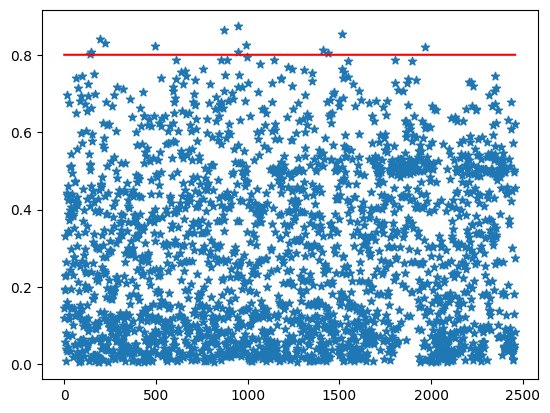

In [ ]:
import matplotlib.pyplot as plt

# PLot das probabilidades
fig, ax = plt.subplots()
cutoff = np.zeros(len(prob_vector)) + 0.8
ax.scatter(range(len(prob_vector)), prob_vector, marker='*')
ax.plot(range(len(prob_vector)), cutoff, color='r')
#plt.savefig(meu_drive + experimento + experimento[:-1] + '_probs.jpg')
plt.show()

# 7. Results
* Imprime compostos promissores

In [ ]:
drugbank_dataset['prediction'] = prob_vector
# Atribuindo ponto de corte para composto melhores classificados
cut_off = drugbank_dataset["prediction"] > 0.85
# Ordenando compostos por probabilidade preditiva
top_compostos_ordenados = drugbank_dataset[cut_off].sort_values('prediction', ascending=False)
top_compostos_ordenados["prediction"]

name
DB01121    0.873136
DB01035    0.864183
DB06795    0.854110
Name: prediction, dtype: float64